# NaiveBayes

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.model_selection import KFold
from sklearn import metrics as mt
import calendar

In [92]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    # Transformamos Capacity a Nominal
    bins = [0,100,200,300, 400]
    labels = [1,2,3,4]
    df['capacidad'] = pd.cut(df["capacity"], bins, labels=labels, right=False)
    df.drop('capacity', axis=1, inplace=True)

    # Transformamos denied_boarding a Nominal
    bins = [0,10,20,30,40,50]
    labels = [1,2,3,4,5]
    df['denied'] = pd.cut(df["denied_boarding"], bins, labels=labels, right=False)
    df.drop('denied_boarding', axis=1, inplace=True)
    
    # Transformamos Capacity a Nominal
    bins = [0,100,200,300,400,500,600,700]
    labels = [1,2,3,4,5,6,7]
    df['booking'] = pd.cut(df["bookings"], bins, labels=labels, right=False)
    df.drop('bookings', axis=1, inplace=True)
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = [1,2,3]
    df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [93]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")

# transformamos los datos a binarios
df["Labels"] = np.where(df["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)

"""
df_procesado.drop('fligth_number', axis=1, inplace=True)
df_procesado.drop('p2p', axis=1, inplace=True)
df_procesado.drop('distance', axis=1, inplace=True)
df_procesado.drop('pax_midlow', axis=1, inplace=True)
df_procesado.drop('pax_high', axis=1, inplace=True)
df_procesado.drop('pax_midhigh', axis=1, inplace=True)
df_procesado.drop('pax_low', axis=1, inplace=True)
df_procesado.drop('pax_freqflyer', axis=1, inplace=True)
df_procesado.drop('group_bookings', axis=1, inplace=True)
df_procesado.drop('out_of_stock', axis=1, inplace=True)
df_procesado.drop('dom_cnx', axis=1, inplace=True)
df_procesado.drop('int_cnx', axis=1, inplace=True)
"""

#df_procesado.drop('bookings', axis=1, inplace=True)
#df_procesado.drop('capacity', axis=1, inplace=True)

#Columnas despues de la limpieza
df_procesado.columns

Index(['fligth_number', 'distance', 'pax_midlow', 'pax_high', 'pax_midhigh',
       'pax_low', 'pax_freqflyer', 'group_bookings', 'out_of_stock', 'dom_cnx',
       'int_cnx', 'p2p', 'origin_int', 'destination_int', 'capacidad',
       'denied', 'booking', 'revenues_usd_discr', 'mes', 'horario'],
      dtype='object')

In [75]:
df_procesado

,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied,booking,revenues_usd_discr,mes,horario
0,8995,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1,3,6,11,1
1,7061,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1,3,2,5,3
2,8972,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1,1,8,5,1
3,6039,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1,1,6,2,3
4,7713,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1,3,8,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1,1,8,10,2
999886,6669,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1,3,10,5,1
999887,9094,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1,2,7,4,2
999888,7704,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1,2,5,4,1


In [135]:
#for k in range (2,100, 5):
kf = KFold(n_splits = 2, shuffle = True, random_state = 42)

NB = MultinomialNB(alpha = 10)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df_procesado):
    
        #extraer los datos de entrenamiento y test
        trainData = df_procesado.iloc[train_index, :]
        testData = df_procesado.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]
        
        rfe = RFE(NB)
        rfe = rfe.fit(trainData, trainLabel)
        i+=1

resultados = [None] * 20

for k in range(20):
    resultados[k] = rfe.support_[k],rfe.ranking_[k]

columnas = pd.DataFrame(resultados, index = df_procesado.columns, columns = ['Support', 'Ranking'])
columnas = columnas.sort_values(by=['Ranking'])
columnas

,Support,Ranking
horario,True,1
revenues_usd_discr,True,1
booking,True,1
pax_high,True,1
pax_midhigh,True,1
denied,True,1
group_bookings,True,1
out_of_stock,True,1
mes,True,1
capacidad,True,1


In [140]:
#Crear un objeto de KFold cross validation

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

kf = KFold(n_splits = 100, shuffle = True, random_state = 0)

TrainF1Score_general = []
TestF1Score_general = []

NB = MultinomialNB(alpha = 100)

for k in range(1,len(df_procesado.columns)+1):
    display(df_procesado[columnas.index].iloc[:,:k])
    
    df_final = df_procesado[columnas.index].iloc[:,:k]

    #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
    F1Train = np.zeros(100)
    F1Test = np.zeros(100)
    
    i=0
    #Aplicar K-fold cross validation
    for train_index, test_index in kf.split(df_final):
            #extraer los datos de entrenamiento y test
            trainData = df_final.iloc[train_index, :]
            testData = df_final.iloc[test_index, :]

            trainLabel = target.iloc[train_index]
            testLabel = target.iloc[test_index]

            #Entrenar el modelo usando los datos de entrenamiento
            NB = NB.fit(trainData, trainLabel)

            #Predecir los valores de TrainData y calcule su error
            prediccion = NB.predict(trainData)
            F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

            #Prediga los valores de testData y calcule su error
            prediccion = NB.predict(testData)
            F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

            i+=1
            
            if(i == 100): 
                TrainF1Score_general.append(F1Train)
                TestF1Score_general.append(F1Test)

            print(i, end=" ")
    print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", F1Train[len(TrainF1Score_general)-1].std())   
    print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

,horario
0,1
1,3
2,1
3,3
4,2
...,...
999885,2
999886,1
999887,2
999888,1


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.0 +- 0.0
F1-score modelo para test:  0.0 +- 0.0


,horario,revenues_usd_discr
0,1,6
1,3,2
2,1,8
3,3,6
4,2,8
...,...,...
999885,2,8
999886,1,10
999887,2,7
999888,1,5


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.0 +- 0.0
F1-score modelo para test:  0.0 +- 0.0


,horario,revenues_usd_discr,booking
0,1,6,3
1,3,2,3
2,1,8,1
3,3,6,1
4,2,8,3
...,...,...,...
999885,2,8,1
999886,1,10,3
999887,2,7,2
999888,1,5,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.0 +- 0.0
F1-score modelo para test:  0.0 +- 0.0


,horario,revenues_usd_discr,booking,pax_high
0,1,6,3,2
1,3,2,3,4
2,1,8,1,1
3,3,6,1,4
4,2,8,3,88
...,...,...,...,...
999885,2,8,1,12
999886,1,10,3,3
999887,2,7,2,1
999888,1,5,2,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.0 +- 0.0
F1-score modelo para test:  0.0 +- 0.0


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh
0,1,6,3,2,28
1,3,2,3,4,4
2,1,8,1,1,5
3,3,6,1,4,7
4,2,8,3,88,18
...,...,...,...,...,...
999885,2,8,1,12,20
999886,1,10,3,3,19
999887,2,7,2,1,0
999888,1,5,2,2,7


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.019700137915017644 +- 0.0
F1-score modelo para test:  0.019725526808831672 +- 0.0030160400976532407


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied
0,1,6,3,2,28,1
1,3,2,3,4,4,1
2,1,8,1,1,5,1
3,3,6,1,4,7,1
4,2,8,3,88,18,1
...,...,...,...,...,...,...
999885,2,8,1,12,20,1
999886,1,10,3,3,19,1
999887,2,7,2,1,0,1
999888,1,5,2,2,7,1


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.017000344794728266 +- 0.0
F1-score modelo para test:  0.016950731062649896 +- 0.0026915028615063937


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings
0,1,6,3,2,28,1,19
1,3,2,3,4,4,1,0
2,1,8,1,1,5,1,0
3,3,6,1,4,7,1,0
4,2,8,3,88,18,1,88
...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0
999886,1,10,3,3,19,1,20
999887,2,7,2,1,0,1,36
999888,1,5,2,2,7,1,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.23410151765046527 +- 0.0
F1-score modelo para test:  0.2340428987956146 +- 0.00887647950659241


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock
0,1,6,3,2,28,1,19,0
1,3,2,3,4,4,1,0,0
2,1,8,1,1,5,1,0,0
3,3,6,1,4,7,1,0,0
4,2,8,3,88,18,1,88,1
...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0
999886,1,10,3,3,19,1,20,0
999887,2,7,2,1,0,1,36,0
999888,1,5,2,2,7,1,0,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.23410706888179805 +- 0.0
F1-score modelo para test:  0.2340447149847489 +- 0.008873658268604088


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes
0,1,6,3,2,28,1,19,0,11
1,3,2,3,4,4,1,0,0,5
2,1,8,1,1,5,1,0,0,5
3,3,6,1,4,7,1,0,0,2
4,2,8,3,88,18,1,88,1,10
...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10
999886,1,10,3,3,19,1,20,0,5
999887,2,7,2,1,0,1,36,0,4
999888,1,5,2,2,7,1,0,0,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.23528927668738767 +- 0.0
F1-score modelo para test:  0.23522652362792687 +- 0.00875770516053679


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad
0,1,6,3,2,28,1,19,0,11,2
1,3,2,3,4,4,1,0,0,5,2
2,1,8,1,1,5,1,0,0,5,3
3,3,6,1,4,7,1,0,0,2,2
4,2,8,3,88,18,1,88,1,10,2
...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2
999886,1,10,3,3,19,1,20,0,5,2
999887,2,7,2,1,0,1,36,0,4,3
999888,1,5,2,2,7,1,0,0,4,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.23547008517959803 +- 0.0
F1-score modelo para test:  0.23542354426393583 +- 0.00880646252442609


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer
0,1,6,3,2,28,1,19,0,11,2,22
1,3,2,3,4,4,1,0,0,5,2,25
2,1,8,1,1,5,1,0,0,5,3,2
3,3,6,1,4,7,1,0,0,2,2,4
4,2,8,3,88,18,1,88,1,10,2,0
...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12
999886,1,10,3,3,19,1,20,0,5,2,2
999887,2,7,2,1,0,1,36,0,4,3,20
999888,1,5,2,2,7,1,0,0,4,2,16


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.23822110766888943 +- 0.0
F1-score modelo para test:  0.23815800885447963 +- 0.008846607449652849


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx
0,1,6,3,2,28,1,19,0,11,2,22,0
1,3,2,3,4,4,1,0,0,5,2,25,9
2,1,8,1,1,5,1,0,0,5,3,2,10
3,3,6,1,4,7,1,0,0,2,2,4,0
4,2,8,3,88,18,1,88,1,10,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9
999886,1,10,3,3,19,1,20,0,5,2,2,118
999887,2,7,2,1,0,1,36,0,4,3,20,0
999888,1,5,2,2,7,1,0,0,4,2,16,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3587366155927027 +- 0.0
F1-score modelo para test:  0.3587047051809549 +- 0.007088957789830815


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx
0,1,6,3,2,28,1,19,0,11,2,22,0,1
1,3,2,3,4,4,1,0,0,5,2,25,9,19
2,1,8,1,1,5,1,0,0,5,3,2,10,0
3,3,6,1,4,7,1,0,0,2,2,4,0,26
4,2,8,3,88,18,1,88,1,10,2,0,3,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64
999886,1,10,3,3,19,1,20,0,5,2,2,118,0
999887,2,7,2,1,0,1,36,0,4,3,20,0,7
999888,1,5,2,2,7,1,0,0,4,2,16,2,34


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3687605522347108 +- 0.0
F1-score modelo para test:  0.3687444064526351 +- 0.006961432776164902


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.39014491094017834 +- 0.0
F1-score modelo para test:  0.39011588043130424 +- 0.007186095452937135


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low,destination_int
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94,125
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87,143
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64,116
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21,33
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4,27
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121,57
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108,125
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42,126


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.39909531218924793 +- 0.0
F1-score modelo para test:  0.39902980072920724 +- 0.007267826136136003


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low,destination_int,origin_int
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94,125,12
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87,143,79
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64,116,122
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21,33,27
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82,55,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4,27,143
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121,57,79
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108,125,62
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42,126,53


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.41503805229841106 +- 0.0
F1-score modelo para test:  0.4149897924182167 +- 0.007224186850968824


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low,destination_int,origin_int,pax_midlow
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94,125,12,94
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87,143,79,100
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64,116,122,7
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21,33,27,54
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82,55,51,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4,27,143,25
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121,57,79,129
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108,125,62,2
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42,126,53,67


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.41455200633470335 +- 0.0
F1-score modelo para test:  0.4144940832346805 +- 0.007391845616560967


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low,destination_int,origin_int,pax_midlow,p2p
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94,125,12,94,239
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87,143,79,100,192
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64,116,122,7,69
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21,33,27,54,64
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82,55,51,21,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4,27,143,25,0
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121,57,79,129,156
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108,125,62,2,124
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42,126,53,67,98


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.43808860869553995 +- 0.0
F1-score modelo para test:  0.4380304154670797 +- 0.005938016891481794


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low,destination_int,origin_int,pax_midlow,p2p,distance
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94,125,12,94,239,1394
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87,143,79,100,192,489
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64,116,122,7,69,2180
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21,33,27,54,64,524
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82,55,51,21,183,1170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4,27,143,25,0,552
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121,57,79,129,156,3934
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108,125,62,2,124,1430
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42,126,53,67,98,1091


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4071492564001511 +- 0.0
F1-score modelo para test:  0.40710028859212016 +- 0.007162205028018146


,horario,revenues_usd_discr,booking,pax_high,pax_midhigh,denied,group_bookings,out_of_stock,mes,capacidad,pax_freqflyer,int_cnx,dom_cnx,pax_low,destination_int,origin_int,pax_midlow,p2p,distance,fligth_number
0,1,6,3,2,28,1,19,0,11,2,22,0,1,94,125,12,94,239,1394,8995
1,3,2,3,4,4,1,0,0,5,2,25,9,19,87,143,79,100,192,489,7061
2,1,8,1,1,5,1,0,0,5,3,2,10,0,64,116,122,7,69,2180,8972
3,3,6,1,4,7,1,0,0,2,2,4,0,26,21,33,27,54,64,524,6039
4,2,8,3,88,18,1,88,1,10,2,0,3,23,82,55,51,21,183,1170,7713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2,8,1,12,20,1,0,0,10,2,12,9,64,4,27,143,25,0,552,6024
999886,1,10,3,3,19,1,20,0,5,2,2,118,0,121,57,79,129,156,3934,6669
999887,2,7,2,1,0,1,36,0,4,3,20,0,7,108,125,62,2,124,1430,9094
999888,1,5,2,2,7,1,0,0,4,2,16,2,34,42,126,53,67,98,1091,7704


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3669169430273177 +- 0.0
F1-score modelo para test:  0.36689730204294607 +- 0.007562840469729383


In [193]:
res = [None] * (len(TestF1Score_general))

variables = 1
for i in range(len(TestF1Score_general)):
    res[i] = [variables, TrainF1Score_general[i].mean(),TrainF1Score_general[i].std(), TestF1Score_general[i].mean(),TestF1Score_general[i].std()]
    variables += 1

resultados = pd.DataFrame(res, columns = ['# Variables','Train Mean','Train std','Test Mean','Test Std'])
resultados

,# Variables,Train Mean,Train std,Test Mean,Test Std
0,1,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000
4,5,0.019700,0.000651,0.019726,0.003016
5,6,0.017000,0.000673,0.016951,0.002692
6,7,0.234102,0.000092,0.234043,0.008876
7,8,0.234107,0.000091,0.234045,0.008874
8,9,0.235289,0.000093,0.235227,0.008758
9,10,0.235470,0.000091,0.235424,0.008806


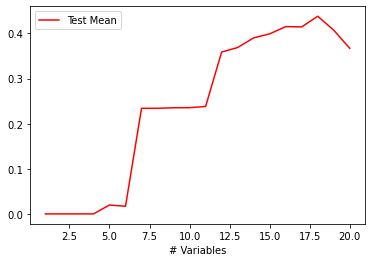

In [209]:
import matplotlib.pyplot as plt



ax = plt.gca()

resultados.plot(kind='line',x='# Variables',y='Test Mean', color='red', ax=ax)

plt.show()

Límites [2.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.38659230e-63
 8.64305697e-67 5.01434726e-71]


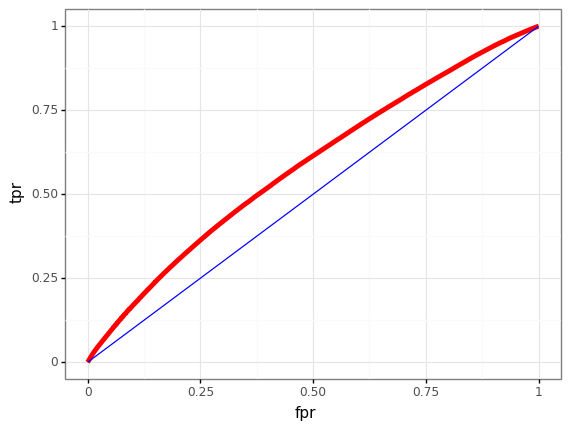


Valor del AUC: 0.5836044403794411


In [208]:
df_final = df_procesado[columnas.index].iloc[:,:18]
#Calculando los tpr and fpr
from sklearn import metrics as mt
NB = MultinomialNB(alpha = 100)
NB.fit(df_final, target)
fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_final)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

# Logistic Regression

In [21]:
from sklearn import preprocessing
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")

# transformamos los datos a binarios
df["Labels"] = np.where(df["noshow"] >= 4, 1,0)

# Convertirmos las columnas origin y destination a variables numericas 
le = preprocessing.LabelEncoder()
ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
le.fit(ciudades)
    
origin_as_int = le.fit_transform(df['origin'])
destination_as_int = le.fit_transform(df["destination"])

df["origin_int"] = origin_as_int
df.drop('origin', axis=1, inplace=True)

df["destination_int"] = destination_as_int
df.drop('destination', axis=1, inplace=True)

# Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df["dia"] = pd.DatetimeIndex(df["date"]).day
df["mes"] = pd.DatetimeIndex(df["date"]).month

#df.departure_time = pd.to_datetime(df.departure_time,  errors='coerce')
#df["hora"] = pd.DatetimeIndex(df["departure_time"]).hour

df.drop('departure_time', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)

# Eliminar columnas sin uso
df.drop('Unnamed: 0', axis=1, inplace=True)

# Definimos nuestra columna target
target = df['Labels']

# La eliminamos del dataframe
df.drop('noshow', axis=1, inplace=True)
df.drop('Labels', axis=1, inplace=True)

In [22]:
for i in df.columns:
    display(pd.isna(df[i]).value_counts())
df

False    999890
Name: fligth_number, dtype: int64

False    999890
Name: distance, dtype: int64

False    999890
Name: denied_boarding, dtype: int64

False    999890
Name: pax_midlow, dtype: int64

False    999890
Name: pax_high, dtype: int64

False    999890
Name: pax_midhigh, dtype: int64

False    999890
Name: pax_low, dtype: int64

False    999890
Name: pax_freqflyer, dtype: int64

False    999890
Name: group_bookings, dtype: int64

False    999890
Name: out_of_stock, dtype: int64

False    999890
Name: dom_cnx, dtype: int64

False    999890
Name: int_cnx, dtype: int64

False    999890
Name: p2p, dtype: int64

False    999890
Name: capacity, dtype: int64

False    999890
Name: revenues_usd, dtype: int64

False    999890
Name: bookings, dtype: int64

False    999890
Name: origin_int, dtype: int64

False    999890
Name: destination_int, dtype: int64

False    999890
Name: dia, dtype: int64

False    999890
Name: mes, dtype: int64

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings,origin_int,destination_int,dia,mes
0,8995,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,10631.1,240,12,125,9,11
1,7061,489,0,100,4,4,87,25,0,0,19,9,192,174.0,5453.7,220,79,143,23,5
2,8972,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,16161.0,79,122,116,9,5
3,6039,524,0,54,4,7,21,4,0,0,26,0,64,174.0,10828.7,90,27,33,12,2
4,7713,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,16721.6,209,51,55,24,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,0,25,12,20,4,12,0,0,64,9,0,144.0,14102.1,73,143,27,16,10
999886,6669,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,32907.8,274,79,57,3,5
999887,9094,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,13519.3,131,62,125,4,4
999888,7704,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,8729.6,134,53,126,4,4


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

#Crear un objeto de KFold cross validation

#for k in range (2,100, 5):
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

#Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
F1Train = np.zeros(5)
F1Test = np.zeros(5)

LR = LogisticRegression(max_iter = 2000)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df):
        #extraer los datos de entrenamiento y test
        trainData = df.iloc[train_index, :]
        testData = df.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]

        #Entrenar el modelo usando los datos de entrenamiento
        #LR = LR.fit(trainData, trainLabel)
        
        rfe = RFE(LR)
        rfe = rfe.fit(trainData, trainLabel)
        print(rfe.support_)
        print(rfe.ranking_)
        
        """
        #Predecir los valores de TrainData y calcule su error
        prediccion = LR.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)
    
        #Prediga los valores de testData y calcule su error
        prediccion = LR.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)
        """
        i+=1

        print(i, end = " ")
print("\nF1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

[False False  True  True False False False  True  True  True False  True
 False  True False  True  True False False  True]
[ 9 10  1  1  2  5  6  1  1  1  4  1  3  1 11  1  1  8  7  1]
1 [False False  True  True False False False  True  True  True False  True
 False  True False  True  True False False  True]
[ 9 10  1  1  2  5  6  1  1  1  4  1  3  1 11  1  1  8  7  1]
2 

/home/matias/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[False False  True  True False False False  True  True  True False  True
 False  True False  True  True False False  True]
[ 9 10  1  1  2  5  6  1  1  1  4  1  3  1 11  1  1  8  7  1]
3 

/home/matias/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[False False  True  True False False False  True  True  True False  True
 False  True False  True  True False False  True]
[ 9 10  1  1  2  5  6  1  1  1  4  1  3  1 11  1  1  8  7  1]
4 [False False  True  True False False False  True  True  True False  True
 False  True False  True  True False False  True]
[ 9 10  1  1  2  5  6  1  1  1  4  1  3  1 11  1  1  8  7  1]
5 
F1-score modelo para training:  0.0 +- 0.0
F1-score modelo para test:  0.0 +- 0.0


In [82]:
#Calculando los tpr and fpr
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_prediccion), pos_label = 0)
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

NameError: name 'df_prediccion' is not defined

In [79]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    df["p2p"] = np.where(df["p2p"] > 0, 1,0)
    df["pax_midlow"] = np.where(df["pax_midlow"] > 0, 1,0)
    df["pax_high"] = np.where(df["pax_high"] > 0, 1,0)
    df["pax_midhigh"] = np.where(df["pax_midhigh"] > 0, 1,0)
    df["pax_low"] = np.where(df["pax_low"] > 0, 1,0)
    df["pax_freqflyer"] = np.where(df["pax_freqflyer"] > 0, 1,0)
    df["group_bookings"] = np.where(df["group_bookings"] > 0, 1,0)
    df["dom_cnx"] = np.where(df["dom_cnx"] > 0, 1,0)
    df["int_cnx"] = np.where(df["int_cnx"] > 0, 1,0)
    
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = [1,2,3]
    df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

Optimal number of features : 1


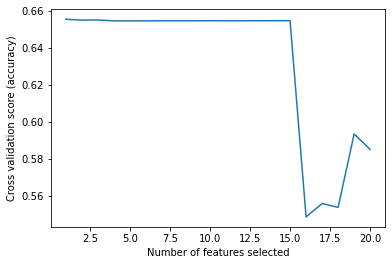

In [81]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


# Create the RFE object and compute a cross-validated score.
NB = MultinomialNB(alpha = 100)
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=NB,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(df_procesado, target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()